# Transformada de Karhunen-Loève (KLT)

## Aplicação a Imagens Binárias

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
from numpy import linalg as LA

### Testes com as funções do numpy

In [3]:
a = np.array([[1,0,3,5,0],
              [0,1,0,2,0]])
x = np.nonzero(a)

print(a)
print('Indices na primeira dimensão dos elementos não nulos:\n', x[0])
print('Indices na segunda  dimensão dos elementos não nulos:\n', x[1])

mu = np.array([[np.mean(x[0])],[np.mean(x[1])]])

print(mu)

Sigma = np.cov([x[0],x[1]])
print(Sigma)

b = np.array([0,0,0,1,1])
c = np.array([0,2,3,1,3])
bm = b - np.mean(b)
cm = c - np.mean(c)
aux = np.sum(bm*cm)/4


Lambda, Phi = LA.eig(Sigma)
Phi = np.array([Phi[:,1],Phi[:,0]])

aux = np.tile(mu,2)
print(x[0].shape[0])

[[1 0 3 5 0]
 [0 1 0 2 0]]
Indices na primeira dimensão dos elementos não nulos:
 [0 0 0 1 1]
Indices na segunda  dimensão dos elementos não nulos:
 [0 2 3 1 3]
[[ 0.4]
 [ 1.8]]
[[ 0.3  0.1]
 [ 0.1  1.7]]
5


### Definição da Transformada

In [4]:
def KLT_bin(f):
    # Baseado na função implementada em
    # http://www.dca.fee.unicamp.br/~lotufo/cursos/ia-636-2000/labs/5rsoares/lab12/index.html
    
    # Vetor aleatorio de duas componentes (indices das linhas e colunas não nulas) com n realizações
    x = np.nonzero(f)
    n = x[0].shape[0]
    
    # Media
    mu = np.array([[np.mean(x[0])],[np.mean(x[1])]])
    
    # Matriz de Covariancia
    Sigma = np.cov([x[0],x[1]])
    
    # Autovalores e autovetores
    Lambda, Phi = LA.eig(Sigma)
    
    # Ordenacao dos autovetores
    if (Lambda[0] < Lambda[1]):
        Phi = np.array([Phi[:,1],Phi[:,0]])
    
    # Centralizacao do vetor
    xc = x - np.tile(mu,n)
    
    # Transformada KLT
    y = Phi.dot(xc)
    
    # Angulo preponderante
    theta = math.acos(Phi[1,1]);
    
    return (y, theta)

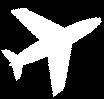

In [5]:
img = Image.open('aviao.tif')
img

Angulo preponderante na imagem:  116.75185388816662


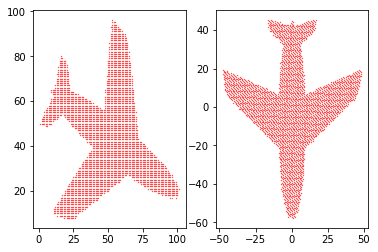

In [6]:
f = np.array(img)
x = np.nonzero(f)
y,theta = KLT_bin(f)

print('Angulo preponderante na imagem: ', theta*180/math.pi)

f, axarr = plt.subplots(1,2)
axarr[0].scatter(x[1],x[0],s=.1,c='r')
axarr[1].scatter(y[1],y[0],s=.1,c='r')

## Aplicação a Imagens RGB

### Definição da Transformada

In [163]:
def KLT_rgb(f,compress=False):
    # Achata os canais RGB para N=3 vetores unidimensionais representando cada canal
    h,w,N = f.shape         # Obtem as dimensoes da imagem
    r = f[:,:,0].flatten()  # Canal vermelho
    g = f[:,:,1].flatten()  # Canal verde
    b = f[:,:,2].flatten()  # Canal azul
    K = h*w                 # Numero de realizacoes = numero de pixels
    
    # Matriz de dados
    X = np.array([r.T,g.T,b.T]).T
    X = np.float_(X)
    
    # Media e centralizacao
    mu = np.mean(X,0)
    X = X - np.tile(mu,[K,1])
    
    # Como K >> N, resolvemos para Sigma_r
    Sigma = X.T.dot(X)/K # (X^T)*X
    
    # Autovalores e autovetores de Sigma_r
    Lambda, U = LA.eig(Sigma)
    
    # Ordenacao dos autovetores
    i = [0,1,2]
    if((Lambda[1] > Lambda[0]) & (Lambda[1] > Lambda[2])):
        i = np.argsort([1,0,2])
    elif((Lambda[2] > Lambda[0]) & (Lambda[2] > Lambda[1])):
        i = np.argsort([1,2,0])
    Lambda = Lambda[i]
    U = U[:,i]
    if(Lambda[2] > Lambda[1]):
        i = np.argsort([0,2,1])
        U = U[:,i]
    
    # Reducao de dimensionalidade
    if(compress):
        U[:,2] = 0
    
    # Transformada KLT
    z = U.T.dot(X.T)
    
    y = np.zeros((h,w,3))
    y[:,:,0] = z[0,:].reshape(h,w)
    y[:,:,1] = z[1,:].reshape(h,w)
    y[:,:,2] = z[2,:].reshape(h,w)
    
    return U,y

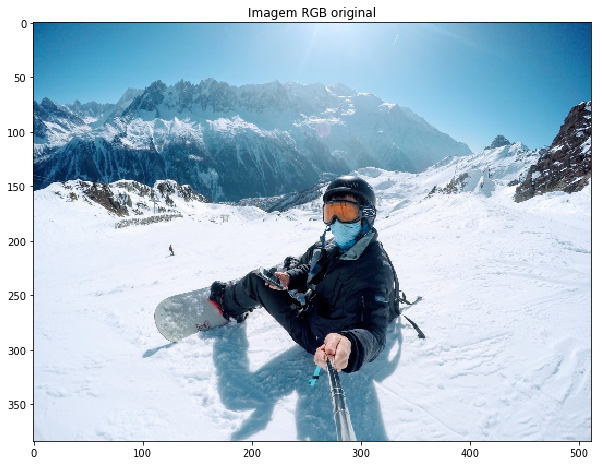

In [164]:
img = Image.open('snow2.tif')

f = np.array(img)
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.imshow(f)
ax1.set_title('Imagem RGB original')

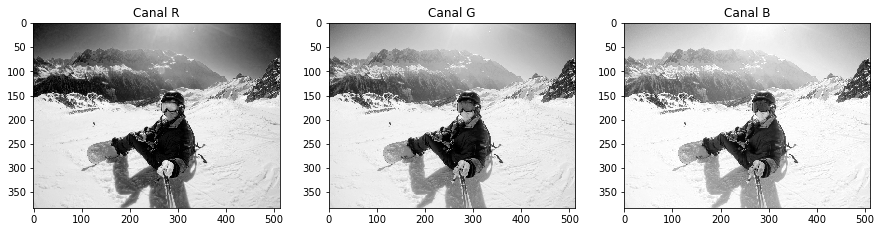

In [165]:
U,y = KLT_rgb(f)

h, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(f[:,:,0],cmap='gray')
axarr[0].set_title('Canal R')
axarr[1].imshow(f[:,:,1],cmap='gray')
axarr[1].set_title('Canal G')
axarr[2].imshow(f[:,:,2],cmap='gray')
axarr[2].set_title('Canal B')

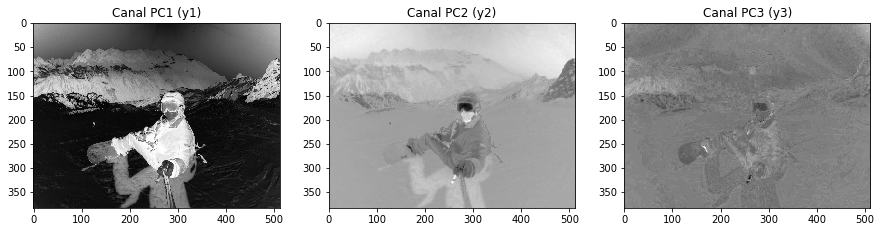

In [166]:
h, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(y[:,:,0],cmap='gray')
axarr[0].set_title('Canal PC1 (y1)')
axarr[1].imshow(y[:,:,1],cmap='gray')
axarr[1].set_title('Canal PC2 (y2)')
axarr[2].imshow(y[:,:,2],cmap='gray')
axarr[2].set_title('Canal PC3 (y3)')